# Health Insurance Cross Sell Prediction

Context
Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

## Data Description

### Train Data
id -> Unique ID for the customer
Gender -> Gender of the customer
Age -> Age of the customer
Driving_License -> 0 : Customer does not have DL, 1 : Customer already has DL
Region_Code -> Unique code for the region of the customer
Previously_Insured -> 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
Vehicle_Age -> Age of the Vehicle
Vehicle_Damage -> 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
Annual_Premium -> The amount customer needs to pay as premium in the year
Policy_Sales_Channel ->	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
Vintage -> Number of Days, Customer has been associated with the company
Response -> 1 : Customer is interested, 0 : Customer is not interested

Evaluation Metric
The evaluation metric for this hackathon is ROC_AUC score.

Public and Private split
The public leaderboard is based on 40% of test data, while final rank would be decided on remaining 60% of test data (which is private leaderboard)

Guidelines for Final Submission
Please ensure that your final submission includes the following:

Solution file containing the predicted response of the customer (Probability of response 1)
Code file for reproducing the submission, note that it is mandatory to submit your code for a valid final submission

## Importar bibliotecas relevantes



In [1]:
import numpy as np
import pandas as pd
import pathlib
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.utils import shuffle
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR

from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
# Importar Tensorflow
import tensorflow as tf

# Importar XGBoost
from xgboost import XGBRegressor

# Importar bibliotecas para testar PyTorch
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm


from sklearn import preprocessing

## Importar Base de Dados

In [2]:
# Load the data
raw_data = pd.DataFrame()

raw_data = pd.read_csv('dataset/train.csv', low_memory=False)

In [3]:
raw_data.head

<bound method NDFrame.head of             id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0            1    Male   44                1         28.0                   0   
1            2    Male   76                1          3.0                   0   
2            3    Male   47                1         28.0                   0   
3            4    Male   21                1         11.0                   1   
4            5  Female   29                1         41.0                   1   
...        ...     ...  ...              ...          ...                 ...   
381104  381105    Male   74                1         26.0                   1   
381105  381106    Male   30                1         37.0                   1   
381106  381107    Male   21                1         30.0                   1   
381107  381108  Female   68                1         14.0                   0   
381108  381109    Male   46                1         29.0                   0  

## Tratamento dos dados
 1) Dados irrelevantes ao modelo
 2) Texto Livre
 3) Colunas repetidas
 4) Valores faltando - Colunas com muitos dados faltantes
 5) Valores faltando - Linhas com dado faltando (NaN)
 6) Avaliar o tipo dos dados de cada coluna

In [4]:
# A primeira coluna é uma coluna de id, que não influencia o resultado
raw_data_semid = raw_data.drop("id", axis=1)

In [5]:
# Não existe coluna com dados faltando
for coluna in raw_data_semid:
    qtd_na = raw_data_semid[coluna].isnull().sum()
    print(f"{coluna} : {qtd_na}")

Gender : 0
Age : 0
Driving_License : 0
Region_Code : 0
Previously_Insured : 0
Vehicle_Age : 0
Vehicle_Damage : 0
Annual_Premium : 0
Policy_Sales_Channel : 0
Vintage : 0
Response : 0


In [6]:
print(raw_data_semid.dtypes)
print('#'*50)
print(raw_data_semid.iloc[0])

Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object
##################################################
Gender                       Male
Age                            44
Driving_License                 1
Region_Code                  28.0
Previously_Insured              0
Vehicle_Age             > 2 Years
Vehicle_Damage                Yes
Annual_Premium            40454.0
Policy_Sales_Channel         26.0
Vintage                       217
Response                        1
Name: 0, dtype: object


In [7]:
gender = raw_data_semid['Gender']
gender.value_counts()

Male      206089
Female    175020
Name: Gender, dtype: int64

In [8]:
va = raw_data_semid['Vehicle_Age']
va.value_counts()

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64

In [9]:
vd = raw_data_semid['Vehicle_Damage']
vd.value_counts()

Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64

In [10]:
# Vehicle_Damage está sendo considerado com object sendo que os valores são Yes e No
raw_data_semid['Vehicle_Damage'].unique()

array(['Yes', 'No'], dtype=object)

In [11]:
# A coluna "Vehicle_Age" contém 3 informações, de idade dos veículos, menor que 1, entre 1 e 2 e mais que 2 anos, vamos considerar 0, 1 e 2 respectivamente
raw_data_semid['Vehicle_Age'].unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [12]:
# A coluna "Gender" contém 2 informações, Male e Female
raw_data_semid['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [13]:
categorical_columns = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
data_dummies = pd.get_dummies(raw_data_semid, columns=categorical_columns, drop_first=True, dtype=int)

## Análise exploratória dos dados
1) Ver a correlação entre as features e decidir se manteremos todas as features que temos.
2) Excluir outliers (usaremos como regra, valores abaixo de (Q1 - 1.5 x Amplitude) e valores acima de (Q3 + 1.5 x Amplitude)). Amplitude = Q3 - Q1
3) Confirmar se todas as features que temos fazem sentido para o nosso modelo ou se alguma delas não vai nos ajudar e devemos excluir

<Axes: >

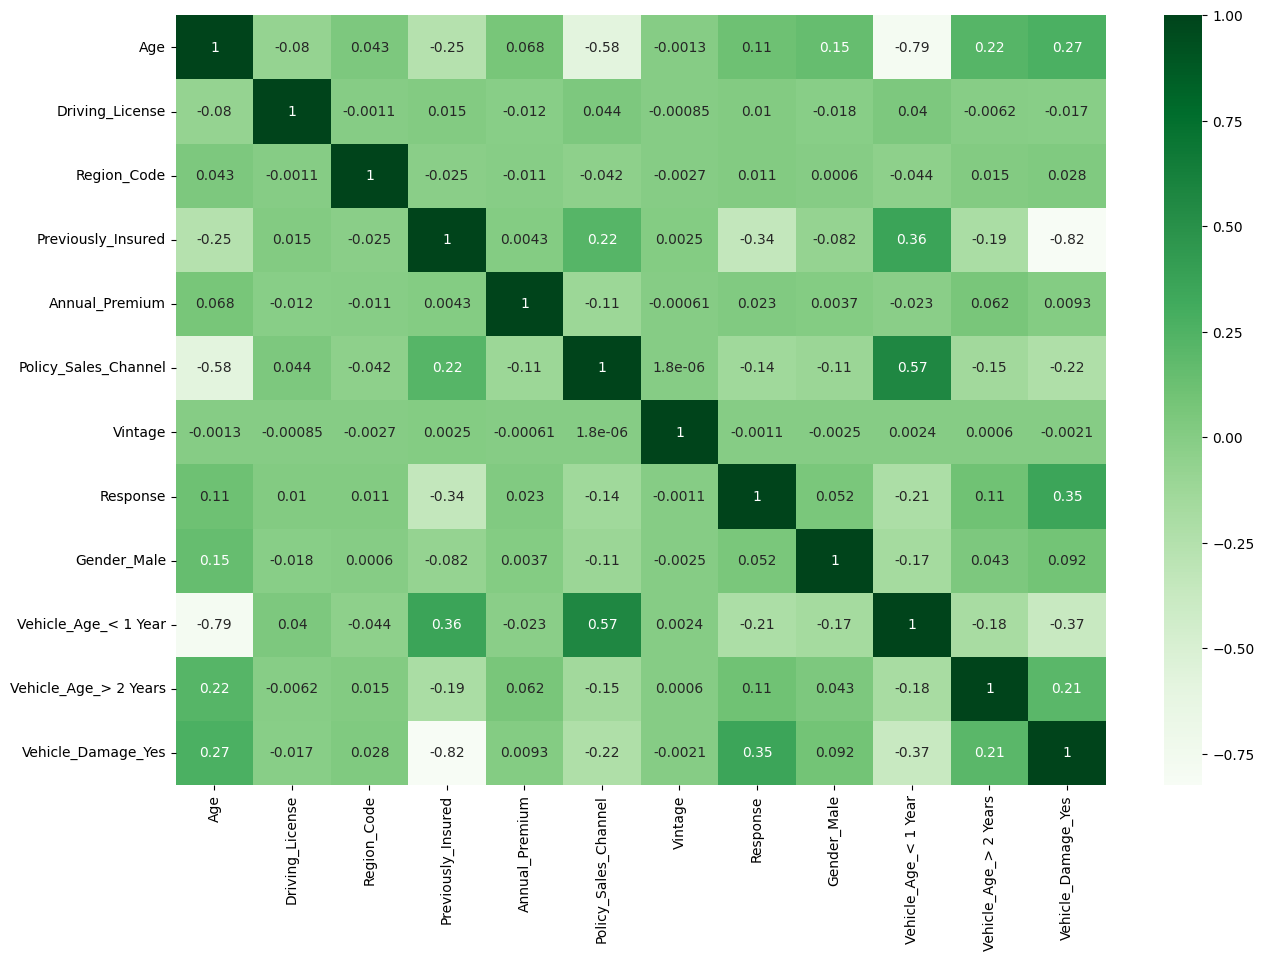

In [14]:
plt.figure(figsize=(15, 10))
sns.heatmap(data_dummies.corr(), annot=True, cmap='Greens')

## Igualar bases (Response 0 e 1)

In [15]:
data_dummies.shape

(381109, 12)

In [16]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude
def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas

In [17]:
# Funções para geração de gráficos de análise
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    
def histograma(coluna):
    plt.figure(figsize=(15, 5)).set_figwidth(15)
    sns.displot(coluna, kind='kde')
    ax2 = plt.twinx()
    ax2 = sns.histplot(coluna, ax=ax2, color='red', binwidth=5)
    plt.show()

def grafico_barra(coluna):  
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

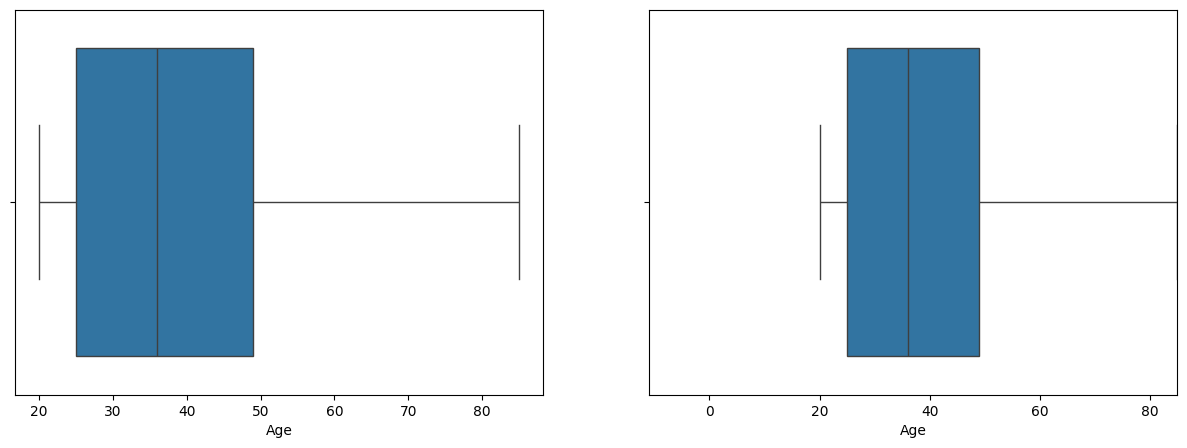

<Figure size 1500x500 with 0 Axes>

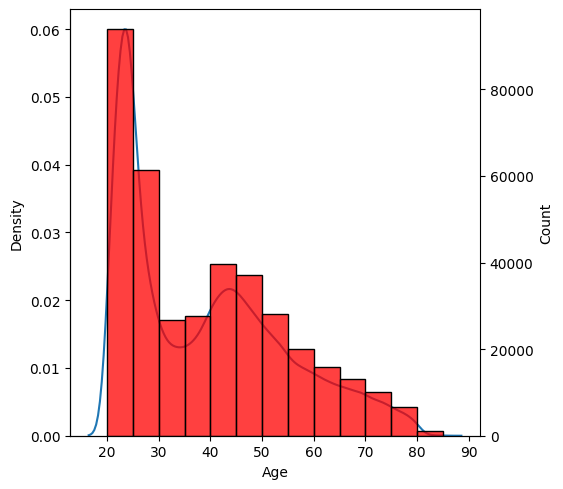

In [18]:
diagrama_caixa(data_dummies['Age'])
histograma(data_dummies['Age'])

In [19]:
dl = data_dummies['Driving_License']
dl.value_counts()

# Menos de 0,5% da base não tem carteira de motorista, o que faz sentido já que quem não tem carteira não deveria ter carro. Neste caso vou desconsiderar esta coluna da base
data_dummies_semdl = data_dummies.drop("Driving_License", axis=1)


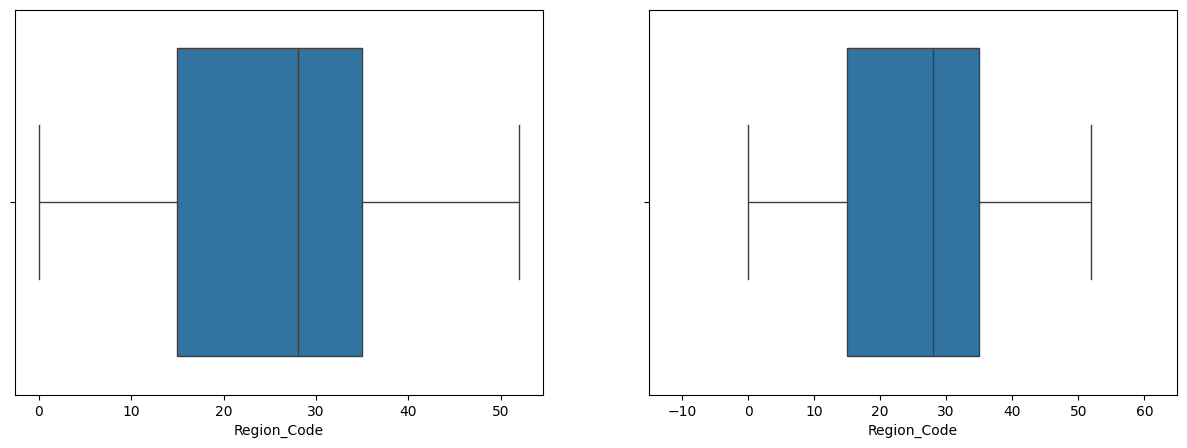

<Figure size 1500x500 with 0 Axes>

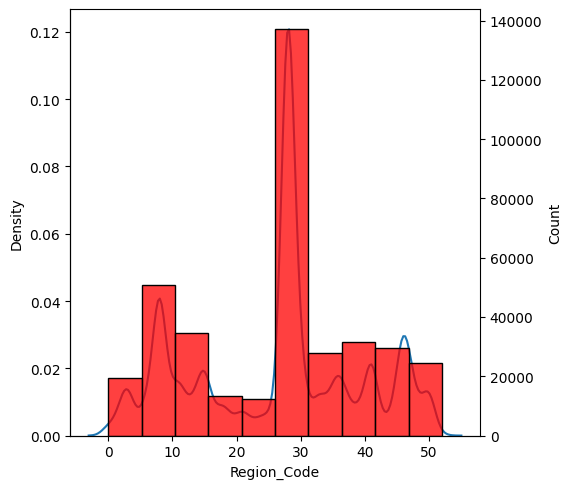

In [20]:
diagrama_caixa(data_dummies_semdl['Region_Code'])
histograma(data_dummies_semdl['Region_Code'])

# Provavelmente o pico é relacionado a uma região onde há maior concentração populacional

In [21]:
pi = data_dummies_semdl['Previously_Insured']
pi.value_counts()

0    206481
1    174628
Name: Previously_Insured, dtype: int64

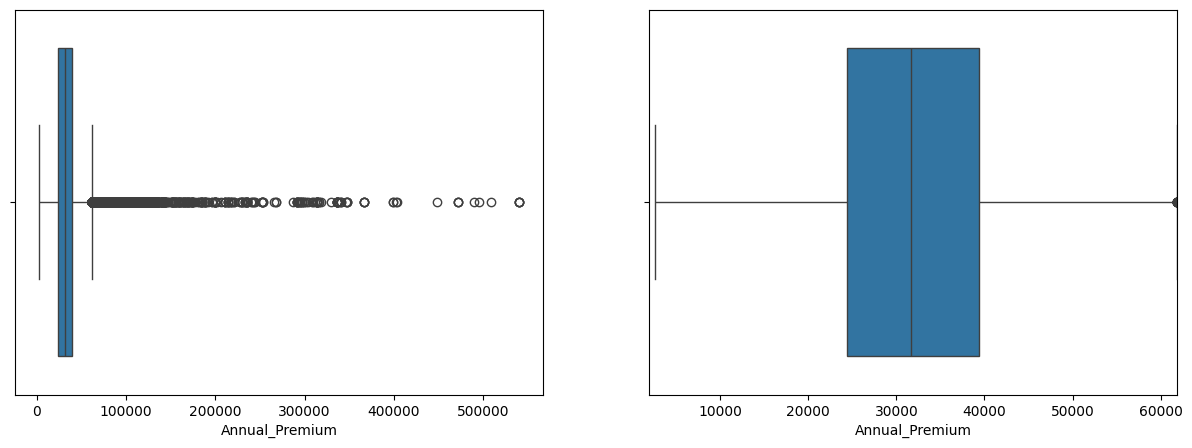

<Figure size 1500x500 with 0 Axes>

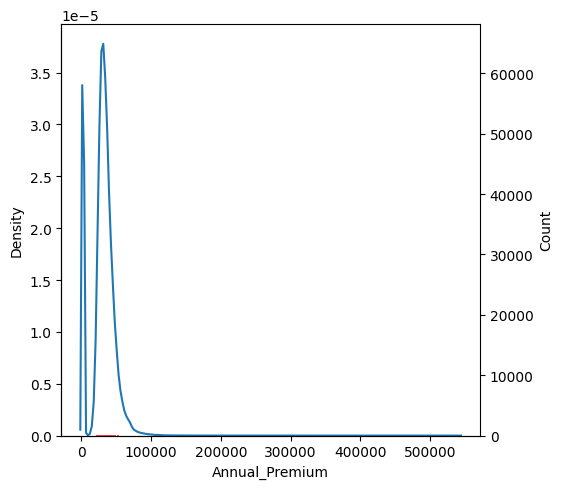

In [22]:
diagrama_caixa(data_dummies_semdl['Annual_Premium'])
histograma(data_dummies_semdl['Annual_Premium'])

In [23]:
# Retirar os outliers
data_dummies_outliers, linhas_removidas = excluir_outliers(data_dummies_semdl, 'Annual_Premium')
print('{} linhas removidas'.format(linhas_removidas))

10320 linhas removidas


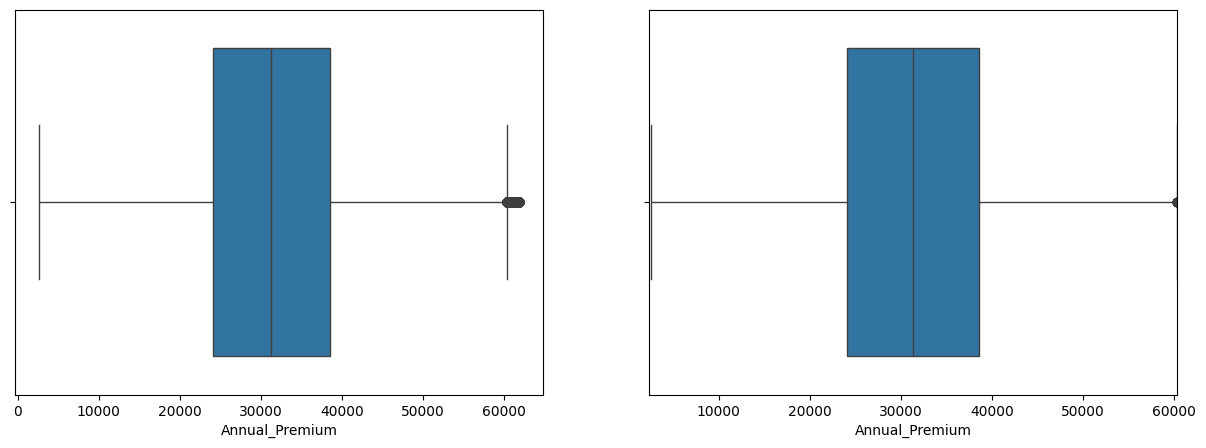

<Figure size 1500x500 with 0 Axes>

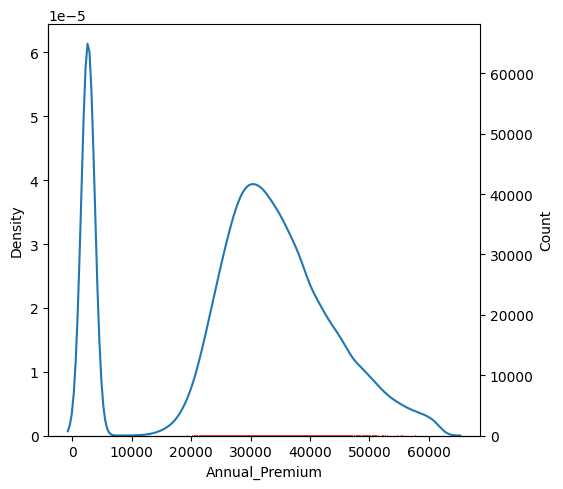

In [24]:
diagrama_caixa(data_dummies_outliers['Annual_Premium'])
histograma(data_dummies_outliers['Annual_Premium'])

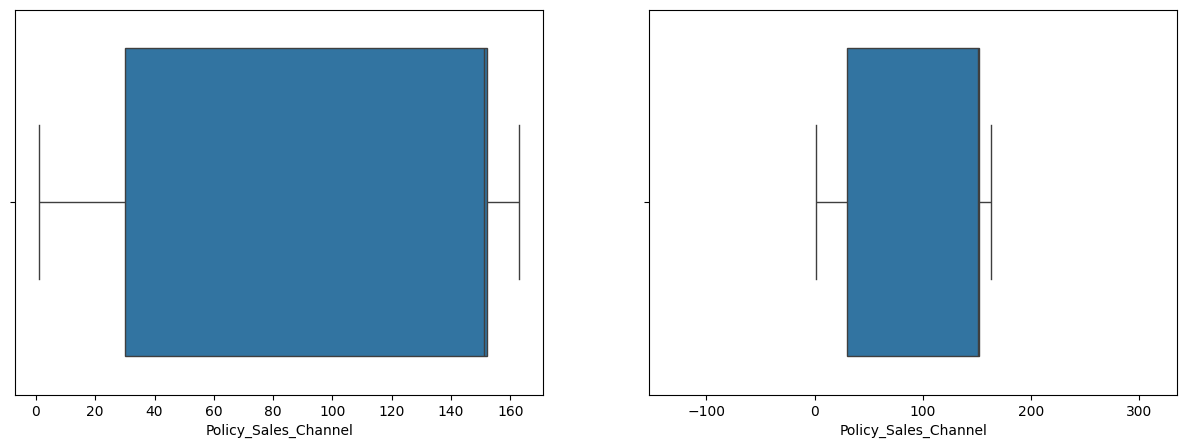

<Figure size 1500x500 with 0 Axes>

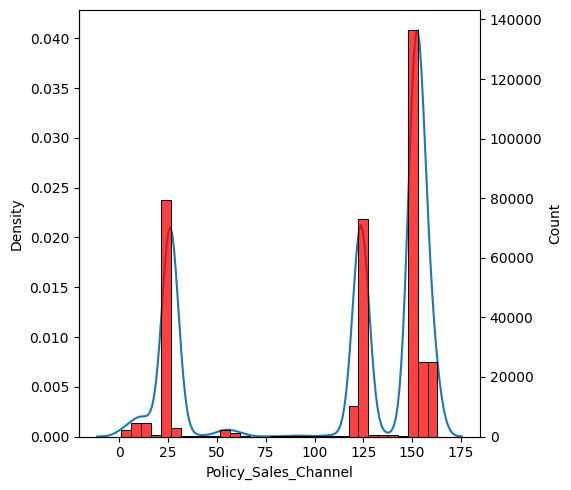

In [25]:
diagrama_caixa(data_dummies_outliers['Policy_Sales_Channel'])
histograma(data_dummies_outliers['Policy_Sales_Channel'])

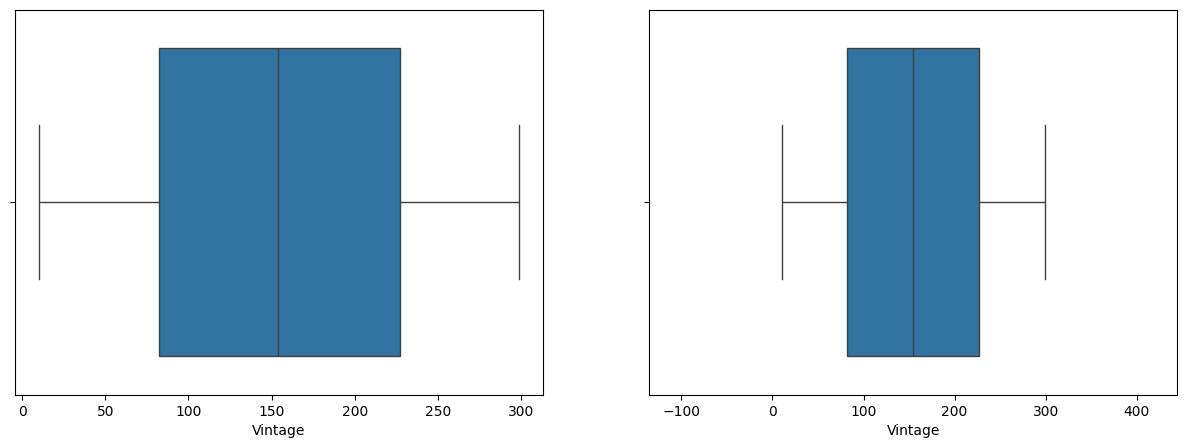

<Figure size 1500x500 with 0 Axes>

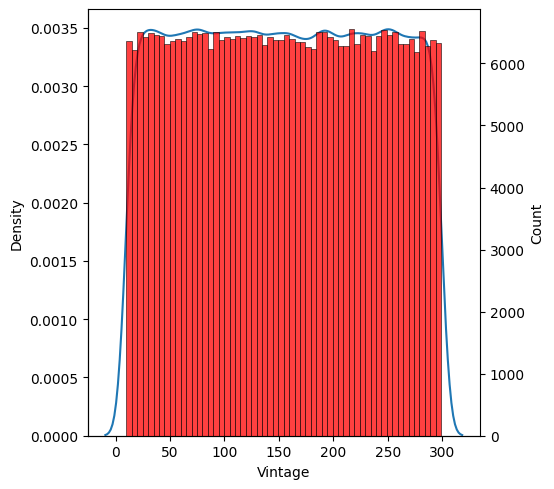

In [26]:
diagrama_caixa(data_dummies_outliers['Vintage'])
histograma(data_dummies_outliers['Vintage'])

In [27]:
data_dummies_outliers.head()

,Age,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,44,28.0,0,40454.0,26.0,217,1,1,0,1,1
1,76,3.0,0,33536.0,26.0,183,0,1,0,0,0
2,47,28.0,0,38294.0,26.0,27,1,1,0,1,1
3,21,11.0,1,28619.0,152.0,203,0,1,1,0,0
4,29,41.0,1,27496.0,152.0,39,0,0,1,0,0


In [28]:
# Para treinar o modelo em identificar a resposta 0 e 1, balancearemos os dados com a mesma quantidade de resposta 0 e 1, assim o modelo não tenderá para o lado que contém a maioria das respostas
response = data_dummies_outliers['Response']
response.value_counts()

0    325634
1     45155
Name: Response, dtype: int64

In [29]:
# Contudo antes de balancear, precisamos 'embaralhar' os dados para tirar qualquer tendência
raw_data_shuffled = shuffle(data_dummies_outliers)
raw_data_shuffled = raw_data_shuffled.reset_index(drop=True)

In [30]:
# Dividir a base em inputs e targets
unscaled_inputs_all = raw_data_shuffled.drop("Response", axis=1)
#unscaled_inputs_all.head()

# The targets are in the last column. That's how datasets are conventionally organized.
targets_all = raw_data_shuffled["Response"]
#targets_all.head()

In [31]:
# Contar o número de respostas 1
num_1s = int(np.sum(targets_all))

# Setar o contador de zeros
contador_zero = 0

# Queremos criar um dataset balanceado, portanto removeremos os dados a partir da quantidade total de resposta 1
indices_to_remove = []

# Contaro número de targets igual a 0. 
# Assim que houver a mesma quantidade de 0 e 1, marcar os demais registros de 0.
for i in range(targets_all.shape[0]):
    if targets_all.iloc[i] == 0:
        contador_zero += 1
        if contador_zero > num_1s:
            indices_to_remove.append(i)

# Criar duas novas variáveis, uma que contém os inputs e outra com os targets
# Apagar todos os itens marcados 'para remoção' do loop anterior
unscaled_inputs_equal_priors = unscaled_inputs_all.drop(indices_to_remove, axis=0)
targets_equal_priors = targets_all.drop(indices_to_remove, axis=0)

In [32]:
# Normalização dos dados Verificar se será necessário

# Rodar o projeto normalizando e sem normalizar os dados para avaliar os resultados
scaled_inputs = preprocessing.scale(unscaled_inputs_equal_priors)


# Modelo de Previsão

- Métricas de Avaliação

Vamos usar aqui o R² que vai nos dizer o quão bem o nosso modelo consegue explicar o resultado. Isso seria um ótimo parâmetro para ver o quão bom é nosso modelo <br>
-> Quanto mais próximo de 100%, melhor (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

Vamos também calcular o R² ajustado, aborda uma limitação do R², especialmente em regressão múltipla (modelos com mais de uma variável independente).

Vou calcular também o Erro Quadrático Médio, que vai mostrar para gente o quanto o nosso modelo está errando. <br>
-> Quanto menor for o erro, melhor

In [33]:
def avaliar_modelo(nome_modelo, y_teste, previsao, X_test):
    r2 = r2_score(y_teste, previsao)
    Adj_r2 = 1 - (1-r2) * (len(y_teste)-1)/(len(y_teste)-X_test.shape[1]-1)
    RMSE = np.sqrt(mean_squared_error(y_teste, previsao))
    #return f'Modelo {nome_modelo}:\nR²:{r2:.2%}\nR² Ajustado:{Adj_r2:.2%}\nRMSE:{RMSE:.2f}'
    return f'Modelo {nome_modelo}:\nR² Ajustado:{Adj_r2:.2%}\nRMSE:{RMSE:.2f}'

- Escolha dos Modelos a Serem Testados (Avaliar modelos de classificação)
    1. RandomForest
    2. LinearRegression
    3. Extra Tree
    4. Linear Support Vector Machine
    5. Stochastic Gradient Descent
    6. TensorFlow
    7. XGBoost
    8. PyTorch
    
Esses são alguns dos modelos que existem para fazer previsão de valores numéricos (o que chamamos de regressão). Estamos querendo calcular o preço, portanto, queremos prever um valor numérico.
https://scikit-learn.org/stable/supervised_learning.html

In [34]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
#modelo_et = ExtraTreesRegressor()
#modelo_sv = make_pipeline(StandardScaler(), SVR()) # Demora muito
#modelo_lsv = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5, dual=True))
modelo_sg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))
#modelo_xgb = XGBRegressor(n_estimators=1000, max_depth=10)
modelo_rc = RidgeClassifier()
modelo_logr = LogisticRegression()
modelo_sgc = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
#modelo_knc = KNeighborsClassifier(n_neighbors=1)

modelos = {
            'RandomForest': modelo_rf,
            'LinearRegression': modelo_lr,
            #'ExtraTrees': modelo_et,
            #'Support Vector Machine': modelo_sv, # demora muito
            #'Linear Support Vector Machine': modelo_lsv,
            'Stochastic Gradient Descent': modelo_sg,
            #'XGBoost': modelo_xgb,
            'Ridge Classifier': modelo_rc,
            'Logistic Regression' : modelo_logr,
            'Stochastic Gradient Classifier': modelo_sgc,
            #'KNeighbors Classifier': modelo_knc,
          }

In [35]:
# y = targets_all
# X = unscaled_inputs_all

y = targets_equal_priors
# X = unscaled_inputs_equal_priors
X = scaled_inputs

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [59]:
# Rodar os modelos

for nome_modelo, modelo in modelos.items():
    horainicio = datetime.datetime.now()
    #treinar
    modelo.fit(X_train, y_train)
    #testar
    previsao = modelo.predict(X_test)
    previsao = previsao.round(decimals=0)
    previsao = previsao.astype(int)

    print(avaliar_modelo(nome_modelo, y_test, previsao, X_test))
    #print(f"Acc Treino: {modelo.score(X_train, y_train):.2%}"), # acurária do treino
    #print(f"Acc Teste: {modelo.score(X_test, y_test):.2%}"), # acurária do teste
    fimteste = datetime.datetime.now()
    duration_total = (fimteste  - horainicio).total_seconds()
    print(f"Tempo total: {divmod(duration_total, 60)[0]}")
    print('#'*50)



Modelo RandomForest:
R² Ajustado:11.80%
RMSE:0.47
Tempo total: 0.0
##################################################
Modelo LinearRegression:
R² Ajustado:12.83%
RMSE:0.47
Tempo total: 0.0
##################################################
Modelo Stochastic Gradient Descent:
R² Ajustado:12.71%
RMSE:0.47
Tempo total: 0.0
##################################################
Modelo Ridge Classifier:
R² Ajustado:12.83%
RMSE:0.47
Tempo total: 0.0
##################################################
Modelo Logistic Regression:
R² Ajustado:12.46%
RMSE:0.47
Tempo total: 0.0
##################################################
Modelo Stochastic Gradient Classifier:
R² Ajustado:13.01%
RMSE:0.47
Tempo total: 0.0
##################################################


# Avaliar Tensowflow

In [60]:
# Dividir o dataframe em bases treino, validação e teste

# Contar o número de dados
contagem_amostras = X.shape[0]

# Numero de amostra em cada base, assumindo uma distribuição de 80-10-10 para treino, validação e teste
# Os numeros devem ser inteiros
contagem_treino = int(0.8 * contagem_amostras)
contagem_validacao = int(0.1 * contagem_amostras)

# A base de teste são os demais dados
contagem_teste = contagem_amostras - contagem_treino - contagem_validacao

shuffled_targets = y
shuffled_inputs = X

# Dimensionar os inputs e targets
# Dimensionar seus dados em aprendizado de máquina (ML) é importante porque muitos algoritmos usam a distância 
# euclidiana entre dois pontos de dados em seus cálculos/derivações, que é sensível à escala das variáveis. 
# Se uma variável estiver em uma escala muito maior que outra, essa variável dominará o cálculo da distância e 
# o algoritmo será mais afetado por essa variável do que pela outra. O dimensionamento dos dados pode ajudar a equilibrar 
# o impacto de todas as variáveis ​​no cálculo da distância e pode ajudar a melhorar o desempenho do algoritmo. Em particular, 
# várias técnicas de ML, como redes neurais, exigem que os dados de entrada sejam normalizados para que funcionem bem.
shuffled_inputs_scaled = preprocessing.scale(shuffled_inputs)
# shuffled_targets_scaled = preprocessing.scale(shuffled_targets)

# OU Sem dimensionar os inputs e targets
# shuffled_inputs_scaled = shuffled_inputs
shuffled_targets_scaled = shuffled_targets

# Criar variaveis para guardar os inputs e precos da base de treino, validação e teste
# Como a base está 'embaralhada', os primeiros dados serão de treino, em seguida validação e por fim teste
train_inputs = shuffled_inputs_scaled[:contagem_treino]
train_targets = shuffled_targets_scaled[:contagem_treino]

validation_inputs = shuffled_inputs_scaled[contagem_treino:contagem_treino+contagem_validacao]
validation_targets = shuffled_targets_scaled[contagem_treino:contagem_treino+contagem_validacao]

test_inputs = shuffled_inputs_scaled[contagem_treino+contagem_validacao:]
test_targets = shuffled_targets_scaled[contagem_treino+contagem_validacao:]

C:\Users\Thiago Kato\AppData\Local\Temp\ipykernel_6992\3469911838.py:34: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_targets = shuffled_targets_scaled[:contagem_treino]
C:\Users\Thiago Kato\AppData\Local\Temp\ipykernel_6992\3469911838.py:37: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  validation_targets = shuffled_targets_scaled[contagem_treino:contagem_treino+contagem_validacao]
C:\Users\Thiago Kato\AppData\Local\Temp\ipykernel_6992\3469911838.py:40: FutureWarning: The

In [61]:
# Definir o tamanho do output
output_size = 1

# Defnir o tamanho do hidden layer. Nao ha necessidade de usar o mesmo tamanhp
hidden_layer_size = 200
    
# Definicao do modelo
model = tf.keras.Sequential([
    # tf.keras.layers.Dense is basically implementing: output = activation(dot(input, weight) + bias)
    # it takes several arguments, but the most important ones for us are the hidden_layer_size and the activation function
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
    
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),

    # tf.keras.layers.Dense(256, activation='relu'), # extra layers
    # tf.keras.layers.Dense(128, activation='relu'), # extra layers
    # tf.keras.layers.Dense(64, activation='relu'), # extra layers
    # tf.keras.layers.Dense(4, activation='relu'), # extra layers
    # tf.keras.layers.Dense(2, activation='relu'), # extra layers

    # O layer final não é diferente. Ferificar a melhor função de ativação
    #tf.keras.layers.Dense(output_size, activation='softplus') # output layer
    tf.keras.layers.Dense(output_size) # output layer
])


### Escolha do otimizador e a função de perda
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
#model.compile(optimizer='sgd', loss='mean_squared_error', metrics=['accuracy'])
#model.compile(optimizer='RMSProp', loss='mean_squared_error', metrics=['accuracy'])
#model.compile(optimizer='Nadam', loss='mean_squared_error', metrics=['accuracy'])

### Treinamento do modelo
# definir o tamanho do lote
batch_size = 32

# Definir o numero maximo de epocas
max_epochs = 50

# Definir um mecanismo de parada antecipada (early stopping)
# Definir patience=2, para ter uma certa tolerancia ao aumento das perdas
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

# fit the model
model.fit(train_inputs, # Input de treinamento
          train_targets, # Targets de treinamento
          batch_size=batch_size, # tamanho do lote
          epochs=max_epochs, # epocas de treinamento (assumindo que nao haja parada antecipada)
          # verifica se a perda esta aumentando
          callbacks=[early_stopping], # early stopping
          validation_data=(validation_inputs, validation_targets), # dados de validacao
          verbose = 2 # informacoes sobre o processo de treinamento
          )  

Epoch 1/50
2258/2258 - 12s - 5ms/step - accuracy: 0.7609 - loss: 0.1517 - val_accuracy: 0.8182 - val_loss: 0.1641
Epoch 2/50
2258/2258 - 9s - 4ms/step - accuracy: 0.7691 - loss: 0.1482 - val_accuracy: 0.8360 - val_loss: 0.1846
Epoch 3/50
2258/2258 - 9s - 4ms/step - accuracy: 0.7702 - loss: 0.1474 - val_accuracy: 0.8258 - val_loss: 0.1579
Epoch 4/50
2258/2258 - 8s - 4ms/step - accuracy: 0.7708 - loss: 0.1470 - val_accuracy: 0.8609 - val_loss: 0.1522
Epoch 5/50
2258/2258 - 8s - 4ms/step - accuracy: 0.7715 - loss: 0.1466 - val_accuracy: 0.7722 - val_loss: 0.2052
Epoch 6/50
2258/2258 - 11s - 5ms/step - accuracy: 0.7712 - loss: 0.1465 - val_accuracy: 0.7906 - val_loss: 0.1896
Epoch 7/50
2258/2258 - 8s - 4ms/step - accuracy: 0.7720 - loss: 0.1463 - val_accuracy: 0.7325 - val_loss: 0.2176
Epoch 8/50
2258/2258 - 8s - 4ms/step - accuracy: 0.7724 - loss: 0.1462 - val_accuracy: 0.8155 - val_loss: 0.1828
Epoch 9/50
2258/2258 - 8s - 4ms/step - accuracy: 0.7739 - loss: 0.1460 - val_accuracy: 0.8153 

In [62]:
prev = model.predict(test_inputs)
prev = prev.round(decimals=0)
prev = prev.astype(int)

print(avaliar_modelo('TensorFlow', test_targets, prev, test_inputs))



283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Modelo TensorFlow:
R² Ajustado:-0.11%
RMSE:0.38


In [63]:
X_train.shape

(67732, 10)

# Avaliar com PyTorch

In [64]:
X_train_tensor = torch.from_numpy(np.array(X_train).astype(np.float32))
y_train_tensor = torch.from_numpy(np.array(y_train).astype(np.float32)).reshape(-1, 1)

X_test_tensor = torch.from_numpy(np.array(X_test).astype(np.float32))
y_test_tensor = torch.from_numpy(np.array(y_test).astype(np.float32)).reshape(-1, 1)

In [65]:
# Define the model
model_pt = nn.Sequential(
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Linear(20, 40),
    nn.ReLU(),
    nn.Linear(40, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    #nn.ReLU(),
    nn.Linear(16, 16),
    #nn.ReLU(),
    nn.Linear(16, 16),
    #nn.ReLU(),
    nn.Linear(16, 16),
    nn.Linear(16, 16),
    nn.Linear(16, 16),
    nn.Linear(16, 16),
    nn.Linear(16, 16),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 1)
)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model_pt.parameters(), lr=0.0001)
#optimizer = optim.SGD(model_pt.parameters(), lr=0.001)

n_epochs = 100   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

In [66]:
patience_pt = 5
horainicio = datetime.datetime.now()

for epoch in range(n_epochs):
    model_pt.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            #X_batch = X_train[start:start+batch_size]
            #y_batch = y_train[start:start+batch_size]
            X_batch = X_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]
            # forward pass
            y_pred = model_pt(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model_pt.eval()
    #y_pred = model_pt(X_test)
    y_pred = model_pt(X_test_tensor)
    #mse = loss_fn(y_pred, y_test)
    mse = loss_fn(y_pred, y_test_tensor)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model_pt.state_dict())
        patience_pt = 5
    else: # Early_Stopping
        patience_pt -= 1
        if patience_pt == 0:
            break

fimteste = datetime.datetime.now()
duration_total = (fimteste  - horainicio).total_seconds()

Modelo PyTorch:
R² Ajustado:16.89%
RMSE:0.46
Tempo total: 7.0


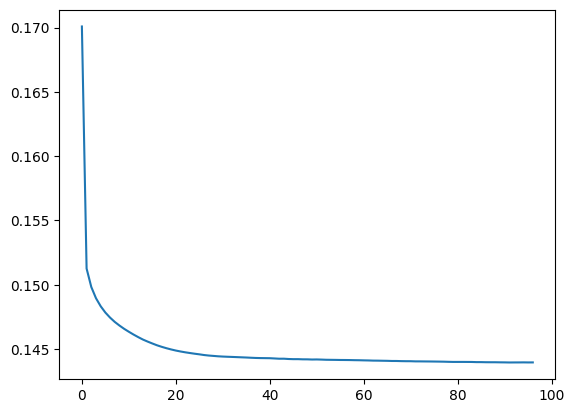

In [67]:
# restore model and return best accuracy
model_pt.load_state_dict(best_weights)

predicted = model_pt(X_test_tensor).data.numpy()
predicted = predicted.round(decimals=0)
predicted = predicted.astype(int)

print(avaliar_modelo('PyTorch', y_test, predicted, X_test))
print(f"Tempo total: {divmod(duration_total, 60)[0]}")

plt.plot(history)
plt.show()

# Adam 10 layers, epoch=100, batch=100, lr=0,0001, patience=5 R2=18,59% - Tempo 7min
# Adam 15 layers, epoch=100, batch=100, lr=0,0001, patience=5 R2=-100,93% - Tempo 2min
# Adam 10 layers, epoch=100, batch=100, lr=0,001, patience=5 R2=18,70% - Tempo 1min
# SGD 10 layers, epoch=100, batch=100, lr=0,001, patience=5 R2=15,98% - Tempo 3min
# Adam 10 layers, epoch=100, batch=1000, lr=0,001, patience=5 R2=18,63% - Tempo 0min
# Adam 10 layers, epoch=100, batch=10, lr=0,001, patience=5 R2=18,17% - Tempo 6min
# Adam 10 layers, epoch=100, batch=32, lr=0,001, patience=5 R2=18,38% - Tempo 2min
# Adam 15 layers, epoch=100, batch=32, lr=0,001, patience=5 R2=17,85% - Tempo 2min
# Adam 10 layers (alt), epoch=100, batch=32, lr=0,001, patience=5 R2=18,47% - Tempo 6min
# Adam 10 layers (alt), epoch=100, batch=32, lr=0,0001, patience=5 R2=18,73% - Tempo 12min
# Adam 10 layers (alt), epoch=100, batch=64, lr=0,0001, patience=5 R2=18,59% - Tempo 7min
# Adam 10 layers (alt), epoch=100, batch=32, lr=0,0001, patience=5 R2=-100,37% - Tempo 9min
# Adam 10 layers, epoch=100, batch=32, lr=0,0001, patience=5 R2=17,48% - Tempo 8min
# Adam 10 layers, epoch=100, batch=32, lr=0,001, patience=5 R2=16,66% - Tempo 2min
# Adam 10 layers, epoch=100, batch=100, lr=0,001, patience=5 R2=16,86% - Tempo 0min
# Adam 10 layers, epoch=100, batch=100, lr=0,0001, patience=5 R2=16,91% - Tempo 5min
# Adam 10 layers, epoch=100, batch=100, lr=0,0001, patience=5 R2=16,91% - Tempo 5min

# Modelo escolhido

Os modelos de melhor resultado foram:
- PyTorch - R² Aj: 17.03% e RMSE: 0.46
- Stochastic Gradient Classifier - R² Aj:13.01% e RMSE:0.47
- LinearRegression: R² Aj:12.83% e RMSE:0.47

O modelo em PyTorch demorou 8 minutos para rodar, já os demais pouco menos de 1 minuto.

A avaliação do modelo levou em consideração o arredondamento do resultado em 0 ou 1, e não os valores decimais pois como resultado gostaríamos de ter uma resposta concreta em cada caso.

In [68]:
# Load test data
test_data = pd.DataFrame()

test_data = pd.read_csv('dataset/test.csv', low_memory=False)

In [69]:
# A primeira coluna é uma coluna de id, que não influencia o resultado, mas será utilizado para o resultado final
test_data_semid = test_data.drop("id", axis=1)
test_data_id = test_data["id"]

In [70]:
categorical_columns = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
test_dummies = pd.get_dummies(test_data_semid, columns=categorical_columns, drop_first=True, dtype=int)

In [71]:
test_dummies_semdl = test_dummies.drop("Driving_License", axis=1)

In [72]:
test_dummies_semdl.head()

,Age,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,25,11.0,1,35786.0,152.0,53,1,1,0,0
1,40,28.0,0,33762.0,7.0,111,1,0,0,1
2,47,28.0,0,40050.0,124.0,199,1,0,0,1
3,24,27.0,1,37356.0,152.0,187,1,1,0,1
4,27,28.0,1,59097.0,152.0,297,1,1,0,0


In [73]:
test_scaled_inputs = preprocessing.scale(test_dummies_semdl)

In [74]:
X_test_predict = test_scaled_inputs
X_test_predict_tensor = torch.from_numpy(np.array(X_test_predict).astype(np.float32))

In [75]:
y_predicted = model_pt(X_test_predict_tensor).data.numpy()
y_predicted = y_predicted.round(decimals=0)
y_predicted = y_predicted.astype(int)

In [81]:
test_data_result = pd.DataFrame(y_predicted)

        0
0       0
1       1
2       1
3       0
4       0
...    ..
127032  0
127033  1
127034  0
127035  0
127036  0

[127037 rows x 1 columns]


In [82]:
matriz_final = pd.DataFrame()

In [83]:
matriz_final['id'] = test_data_id

In [84]:
matriz_final['result'] = test_data_result

In [85]:
display(matriz_final)

,id,result
0,381110,0
1,381111,1
2,381112,1
3,381113,0
4,381114,0
...,...,...
127032,508142,0
127033,508143,1
127034,508144,0
127035,508145,0


In [86]:
matriz_final.to_csv('dataset/result.csv')